# 0 Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Import helper functions
from utils import data_download
from data_setup import create_dataloaders

# 1 Get Data

In [4]:
image_path = data_download(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2 Create Datasets and Data Loaders

In [6]:
# create manual transforms:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
BATCH_SIZE = 32 
train_dataloader, test_dataloader , class_names = create_dataloaders(
                                                    train_dir,
                                                    test_dir, 
                                                    manual_transforms, 
                                                    BATCH_SIZE
                                                )

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

print(image.shape, label)

torch.Size([3, 224, 224]) tensor(2)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

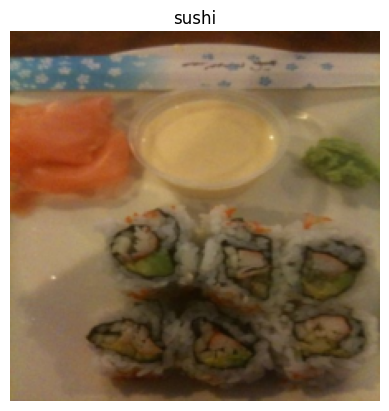

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

# 3 Model Archtiecture

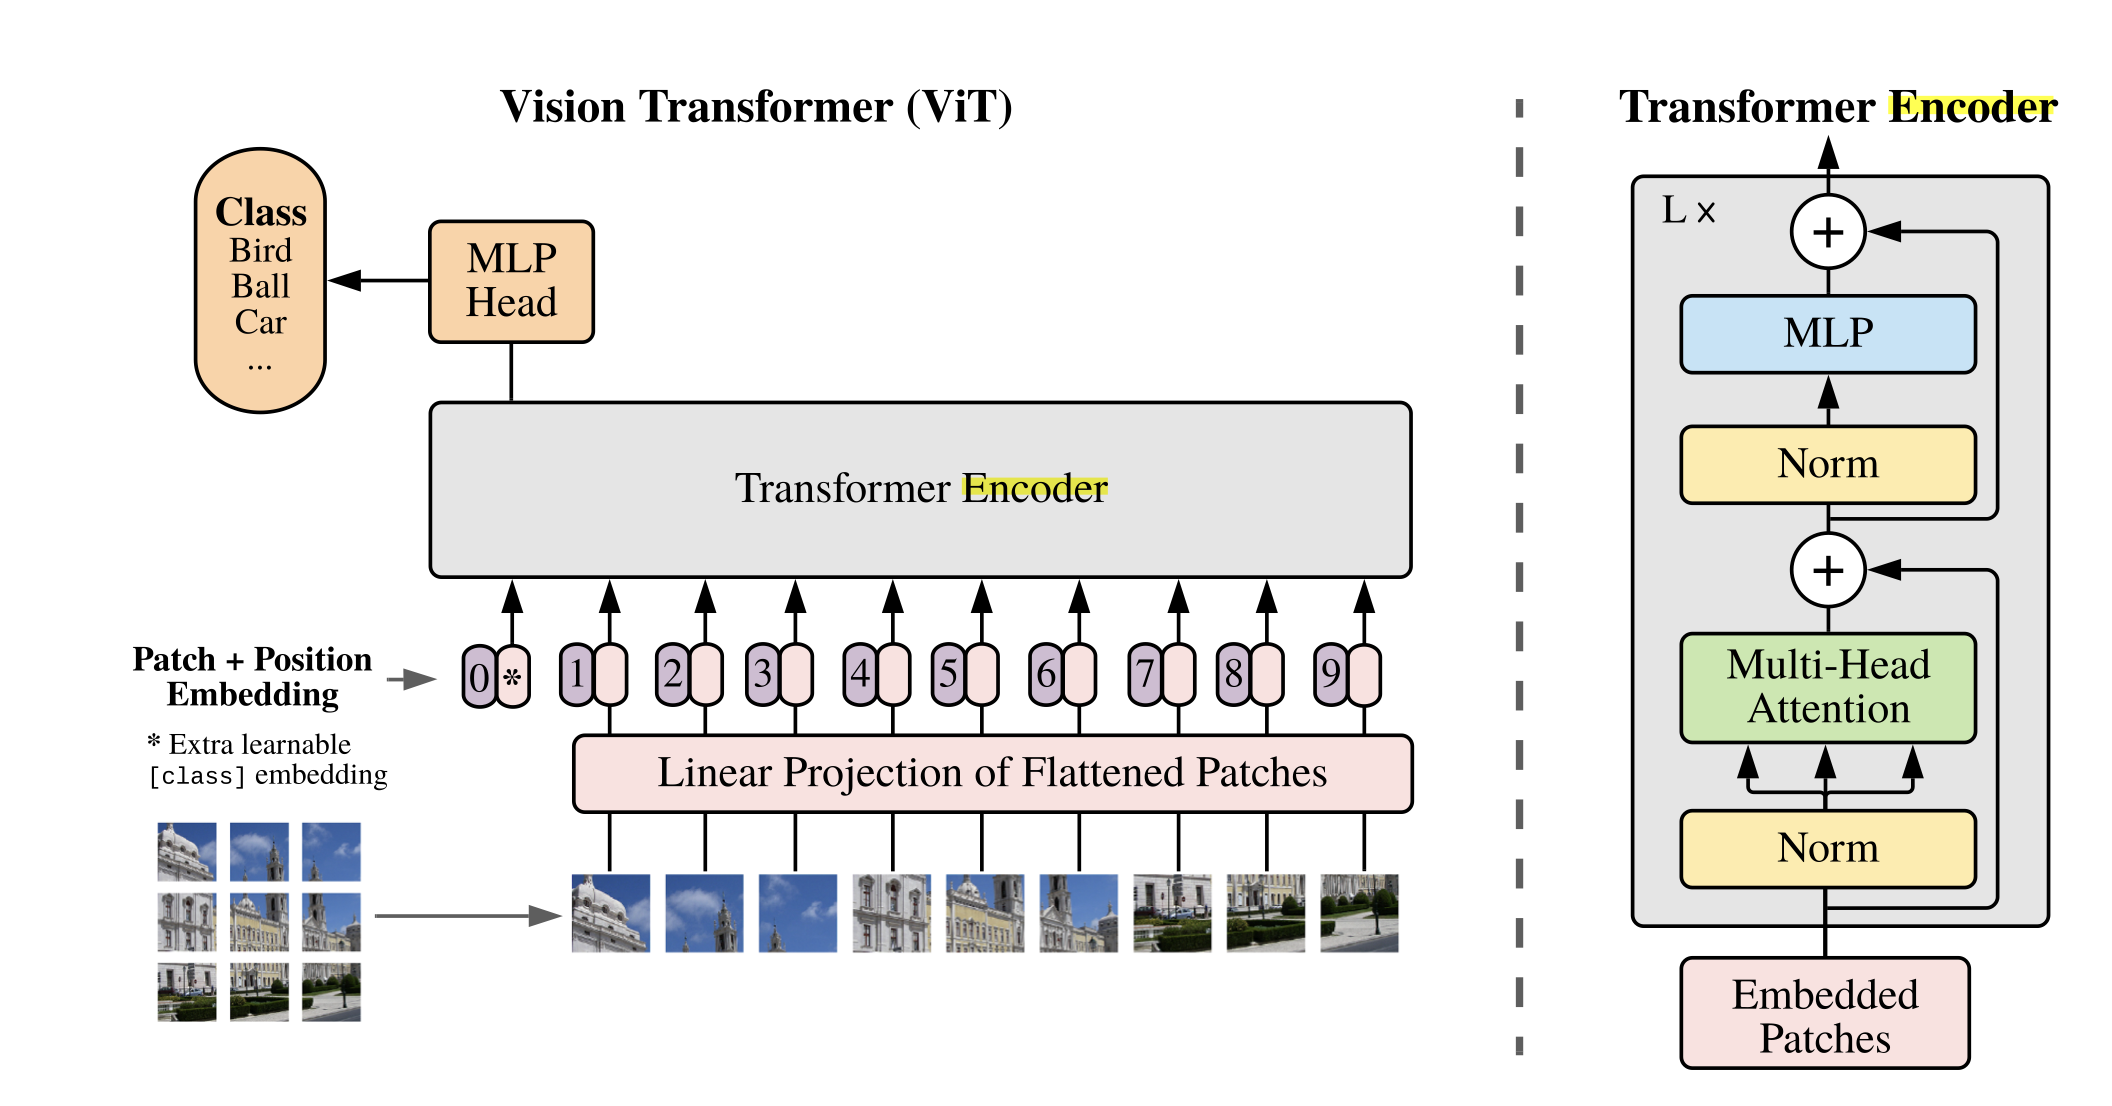

## Equations: 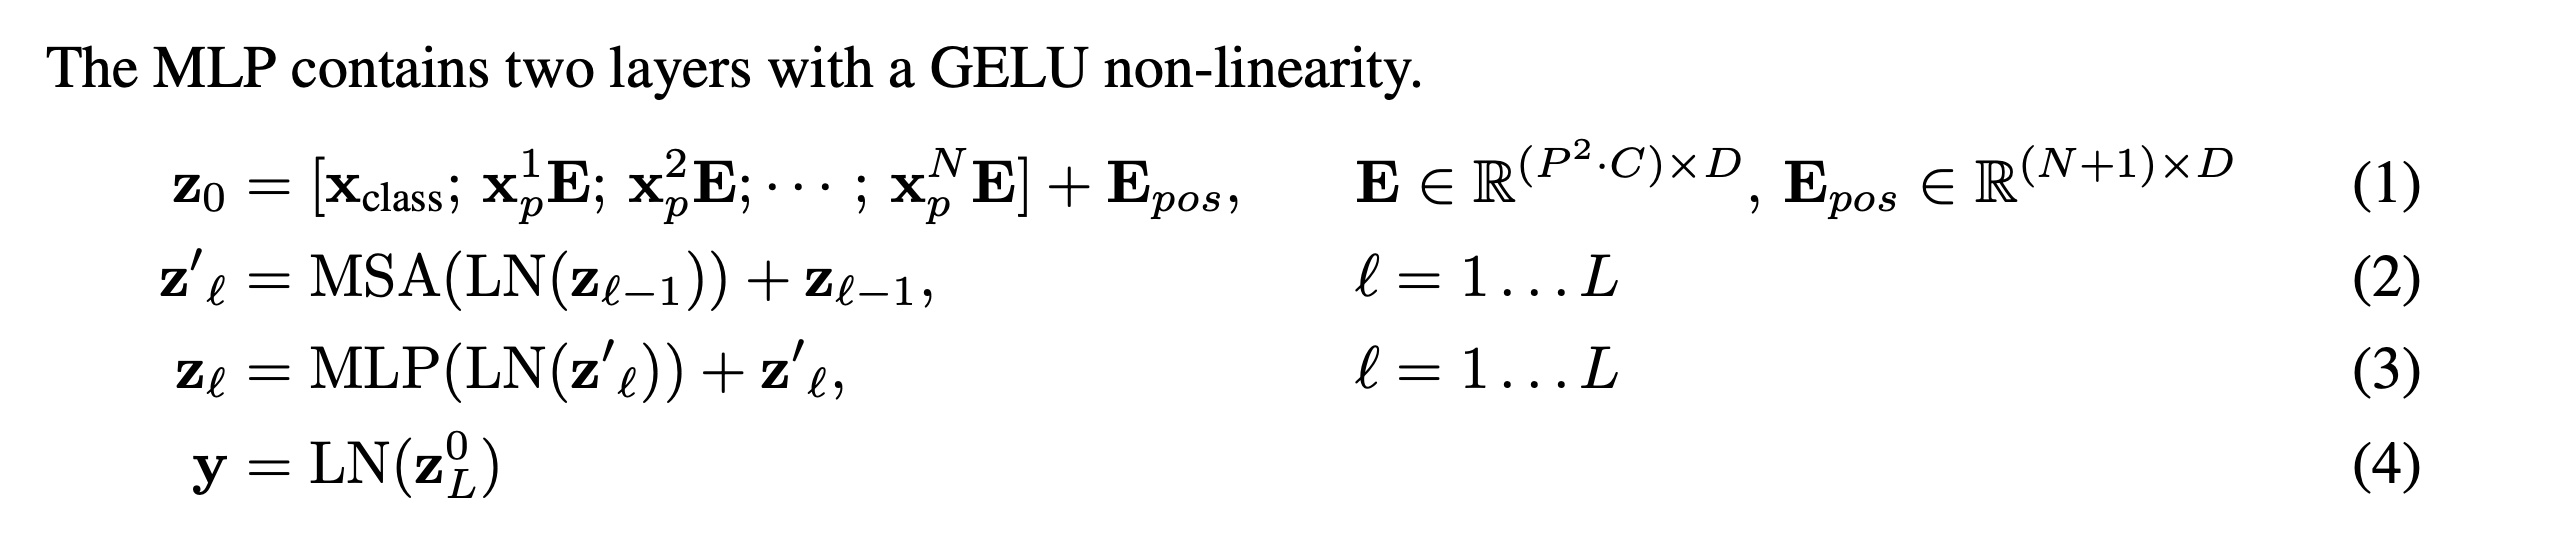

# 3.1 Embedding Patches (Z0)

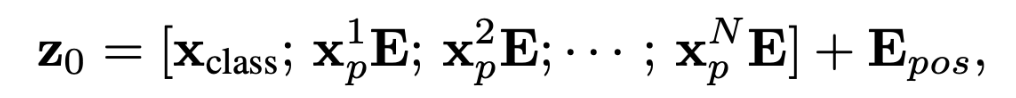

- Create patches (X_class)
- Concat class to patches 
- Add positional embedding (E_pos)

## 3.1.1 Patching the image

In [10]:
# Vit-base model uses a aptch size of 16

# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


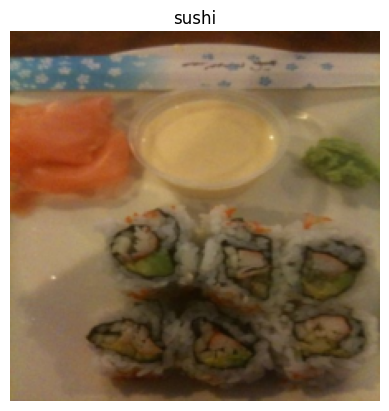

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

Number of patches per row ; 14.0
Number of patches per column: 14.0
Total patches: 196.0
patch size: 16 pixels * 16 pixels


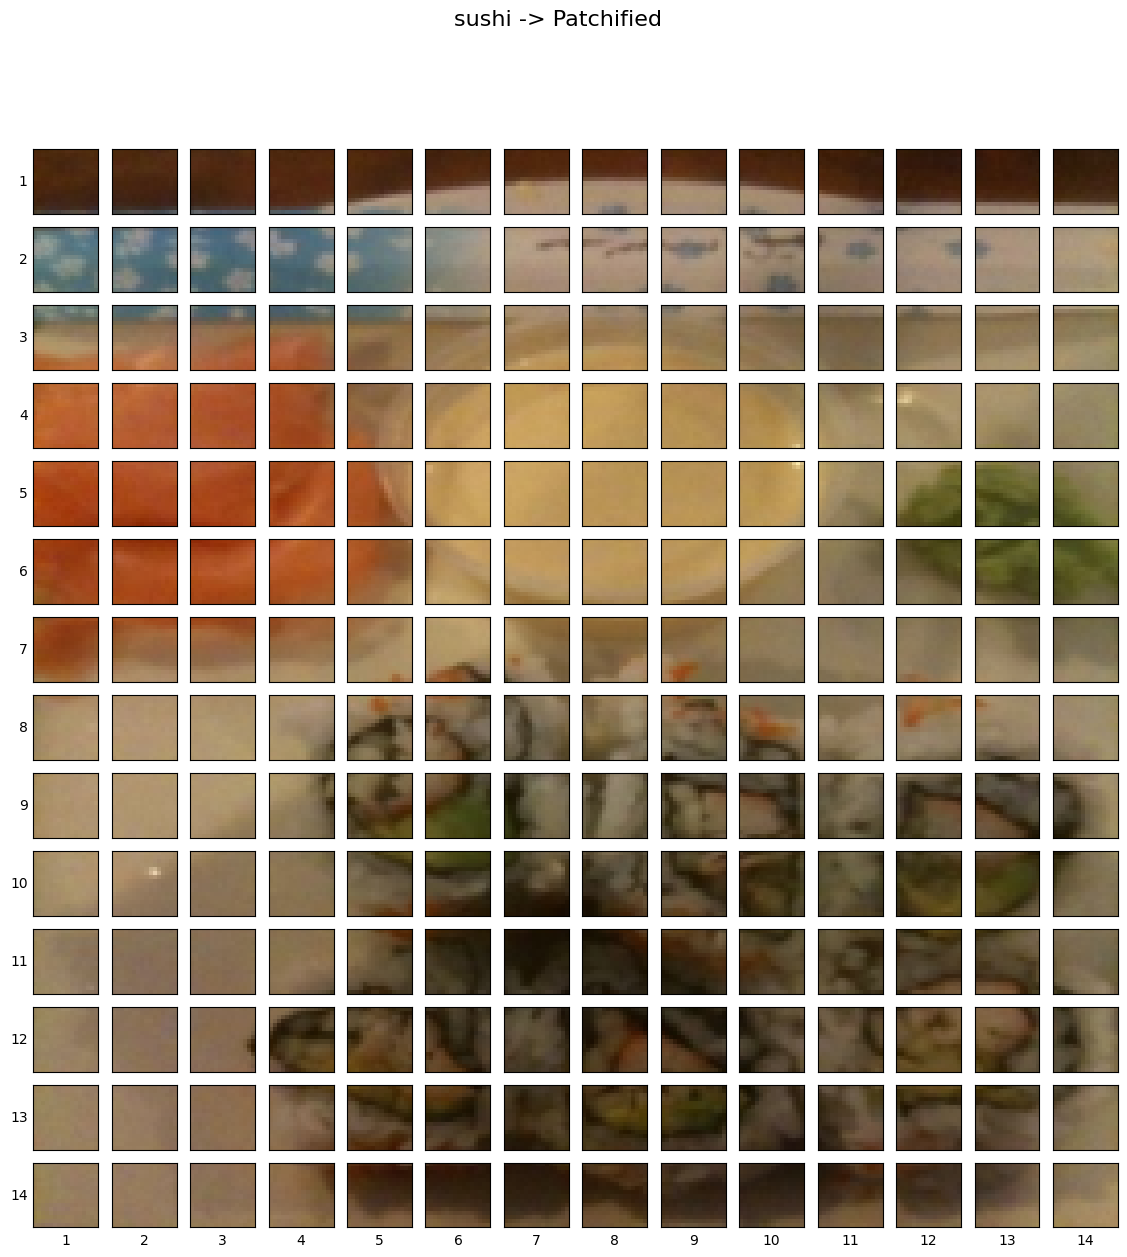

In [13]:
# convert single image to patches:

img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Rearrange dims to make compatible with matplotlib - (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)  

print(f"Number of patches per row ; {img_size / patch_size}")
print(f"Number of patches per column: {img_size / patch_size}")
print(f"Total patches: {num_patches * num_patches}")
print(f"patch size: {patch_size} pixels * {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j , patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # all the color channels. 

        axs[i, j].set_ylabel(i+1,rotation="horizontal",
                                horizontalalignment="right",
                                verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()
                            

### Creating pathes with Conv2D. 
- Instead of iterating and creating patches manually, we can use the torch Conv2D layer to create patches. 
- Set the kernel_size and stride equivalent to the patch size. 
- Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN.


### We can recreate these with:

- torch.nn.Conv2d() for turning our image into patches of CNN feature maps.
- torch.nn.Flatten() for flattening the spatial dimensions of the feature map.

In [14]:
from torch import nn 

patch_size = 16
conv2d = nn.Conv2d(in_channels = 3,
                    out_channels = 768,
                    kernel_size = patch_size,
                    stride = patch_size,
                    padding = 0)

'''
Why 768?

for an image of 224 with 3 channels, when converted to patches of size: 16x16
There are 196 patches made. Each patch with have patch_size * patch_size * 3 (channels) pixels. 
Hence we consider output embedding dimension to be ---> 768 [patch_size * patch_size * 3 (channels)] OR [16*16*3]
'''


'\nWhy 768?\n\nfor an image of 224 with 3 channels, when converted to patches of size: 16x16\nThere are 196 patches made. Each patch with have patch_size * patch_size * 3 (channels) pixels. \nHence we consider output embedding dimension to be ---> 768 [patch_size * patch_size * 3 (channels)] OR [16*16*3]\n'

torch.Size([1, 768, 14, 14])


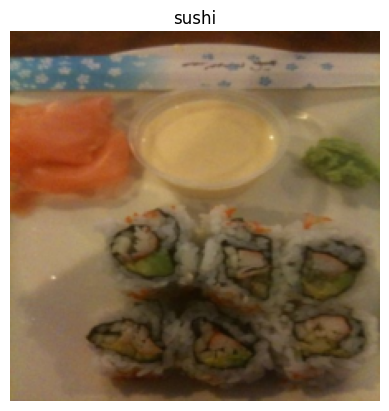

In [15]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

# [batch_size, embedding_dim, feature_map_height, feature_map_width]

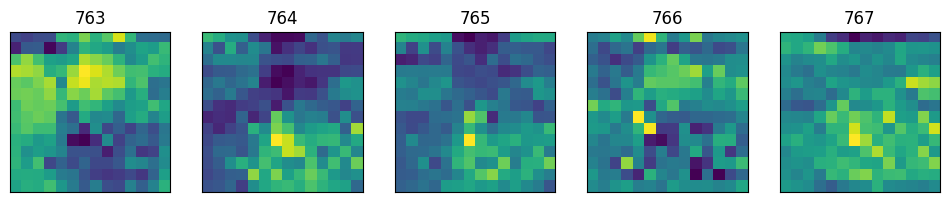

In [16]:
# Printing random feature maps of patches:

import random
random_indexes = random.sample(range(0,758), k=5)
fig, axs = plt.subplots(nrows=1, ncols= 5, figsize = (12,12))

for i, idx in enumerate([763, 764, 765, 766, 767]):
    img_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
    axs[i].title.set_text(idx)
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [17]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

'''
of the 4 dimensions, [batch_size, embedding_dim, feature_map_height, feature_map_width]
We only want to flatten the height and widht (spatial dimenesions) of the feature map. 
'''

'\nof the 4 dimensions, [batch_size, embedding_dim, feature_map_height, feature_map_width]\nWe only want to flatten the height and widht (spatial dimenesions) of the feature map. \n'

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


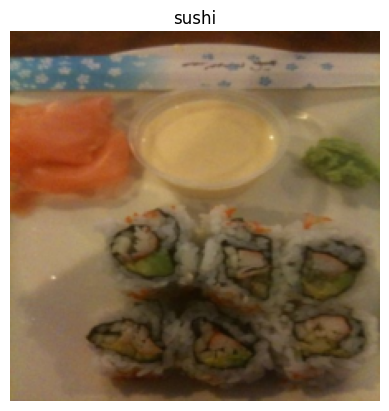

In [18]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


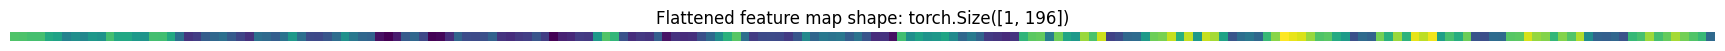

In [19]:
#4. permute to deisred output dimensions: (1,768,196) --->(1, 196, 768))
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the reshaped image: 
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [20]:
# import patch embedding class and create flattened patches
from embedding import PatchEmbedding
from utils import set_seeds

set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [23]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 3.1.2 Adding class label to patches 